In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import torch 
from torch.autograd import Variable
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

In [2]:
# Rutas de los archivos
train_files = glob('mnist/train/*/*.png')
valid_files = glob('mnist/valid/*/*.png')
test_files = glob('mnist/test/*/*.png')

print('Primer ruta es: ',train_files[0])

# Se vueleven aleatorios los archivos
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

print('Las longitudes son: train {}, valid {}, test {}'.format(len(train_files), len(valid_files), len(test_files)))

# Se cargan las imagenes en las listas
# Datos de entrenamiento
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
    Y_train.append(int(train_file.split('/')[2]))
    X_train.append(np.array(Image.open(train_file)))

# Datos de validación 
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
    Y_valid.append(int(valid_file.split('/')[2]))
    X_valid.append(np.array(Image.open(valid_file)))

# Datos de prueba
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
    Y_test.append(int(test_file.split('/')[2]))
    X_test.append(np.array(Image.open(test_file)))

print('Verificamos las longitudes: Tr {}, V {}, Te {}'.format(len(X_train), len(X_valid), len(X_test)))

def tensor (X,Y):
    X = Variable(torch.from_numpy(np.array(X))).float()
    Y = Variable(torch.from_numpy(np.array(Y))).long()
    return X,Y

def entrena(X_train,Y_train,X_valid,Y_valid,X_test, Y_test,model, ne, optimizer, criterion):
    # Listas de evaluacion del entrenamiento
    loss_train = []
    f1_train = []
    acc_train = []

    # Listas de evaluacion de la validacion
    loss_valid = []
    f1_valid = []
    acc_valid = []

    total_it = 0

    # Se entrena la red
    for epoch in range(ne):
        model.train()

        Xtr = X_train.view(X_train.size(0), -1)
        Y_pred = model(Xtr)

        loss = criterion(Y_pred,Y_train)
        loss_train.append(loss.item())

        Y_pred = torch.argmax(Y_pred, 1)
        f1_train.append( f1_score(Y_train,Y_pred, average='macro') )

        acc = sum(Y_train == Y_pred)/len(Y_pred)
        acc_train.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        Xvl = X_valid.view(X_valid.size(0), -1)
        Y_pred = model(Xvl)  
        loss = criterion(Y_pred,Y_valid)
        loss_valid.append(loss.item())

        Y_pred = torch.argmax(Y_pred, 1)
        f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

        acc = sum(Y_valid == Y_pred)/len(Y_pred)
        acc_valid.append(acc)

    CM(Y_valid, Y_pred, 10)
    
    return loss_valid[-1], f1_valid[-1], acc_valid[-1]

def modelo1(input_dim,out_dim,hidden):
    model = torch.nn.Sequential(
        torch.nn.Linear(input_dim, hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden, out_dim)
    )
    return model

def modelo2(input_dim,out_dim,hidden):
    model = torch.nn.Sequential(
        torch.nn.Linear(input_dim, hidden),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden, hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden, hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden, out_dim)
    )
    return model
    

def red(X_train,Y_train,X_valid,Y_valid,X_test, Y_test,n_epoch,batch_size,learning_rate,weight_decay,hd_list,modelo,values,pbar,final):
    
    for ne in n_epoch:
        for bs in batch_size:
            train_ds = TensorDataset(X_train, Y_train)
            train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

            for lr in learning_rate:
                for wd in weight_decay:
                    for hd in hd_list:
                        
                        print('*')
                        print('Esta cargando para {} epocas, {} Learning Rate, {} Weight Decay y {} Batch Size.'.format(ne,hd,wd,bs))
                        print('')
                        
                        # Dimensiones de la red neuronal
                        input_dim = 28*28
                        out_dim = 10
                        hidden = hd

                        # Se hace el modelo con las dimensiones anteriores
                        model = modelo(input_dim,out_dim,hidden)
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                        criterion = torch.nn.CrossEntropyLoss()
                        
                        loss,f1,acc=entrena(X_train,Y_train,X_valid,Y_valid,X_test, Y_test,model,ne,optimizer,criterion)
                        
                        values['ne{}, hd{}, wd{}, bs{}'.format(ne,hd,wd,bs)]={'loss':loss,'f1':f1,'acc':acc}
                        print('')
                        print('')
                        print('Con {} epocas, {} Learning Rate, {} Weight Decay y {} Batch Size se tiene: loss: {}, f1: {}, acc: {}'.format(ne,hd,wd,bs,loss,f1,acc))
                
                        pbar.update()
    pbar.close()
    
    
    
def CM(Y_true, Y_pred, classes):
    fig = plt.figure(figsize=(10, 10))
    cm = confusion_matrix(Y_true, Y_pred)
    lclasses = np.arange(0,classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmap=plt.cm.Blues
    ax = fig.add_subplot(1,1,1)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
    ax.set_xlabel("Predicted",size=20)
    ax.set_ylabel("True",size=20)
    ax.set_ylim(classes-0.5, -0.5)

    plt.setp(ax.get_xticklabels(), size=12)
    plt.setp(ax.get_yticklabels(), size=12)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

    plt.show()
    return fig


def metodo (n_epoch,lr,weight,batch,hd_list):
    X_train_p, Y_train_p = tensor(X_train, Y_train)
    X_valid_p, Y_valid_p = tensor(X_valid, Y_valid)
    X_test_p, Y_test_p = tensor(X_test, Y_test)
    
    modelo = [modelo1,modelo2]
    
    final = []
    for m in range(len(modelo)):
        pbar = tqdm(total=len(batch)*len(lr)*len(weight)*len(hd_list)*len(n_epoch))
        values = {}
        print('*')
        print('*')
        print('Utilizando el modelo {}'.format(m+1))
        print('*')
        red(X_train_p,Y_train_p,X_valid_p,Y_valid_p,X_test_p,Y_test_p,n_epoch,batch,lr,weight,hd_list,modelo[m],values,pbar,final)
        print('*')
        print('*')
        print('*')
        print('El orden de menor a mayor de los parametros es:')
        print('*')
        print('Para la perdida:')
        loss = dict(sorted(values.items(), key=lambda k_v: k_v[1]["loss"]))
        loss1 = list(loss.items())
        print(loss)
        print('*')
        print('Para el f1:')
        f1 = dict(sorted(values.items(), key=lambda k_v: k_v[1]["f1"],reverse=True))
        f11 = list(f1.items())
        print(f1)
        print('*')
        print('Para la acc:')
        acc = dict(sorted(values.items(), key=lambda k_v: k_v[1]["acc"],reverse=True))
        acc1 = list(acc.items())
        print(acc)
        final.append({'loss':loss1[0],'f1':f11[0],'acc':acc1[0]})
    print('*')
    print(final)
    return final
    
    

Primer ruta es:  mnist/train/9/4968.png
Las longitudes son: train 6000, valid 2000, test 992
Verificamos las longitudes: Tr 6000, V 2000, Te 992


  0%|          | 0/32 [00:00<?, ?it/s]

*
*
Utilizando el modelo 1
*
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



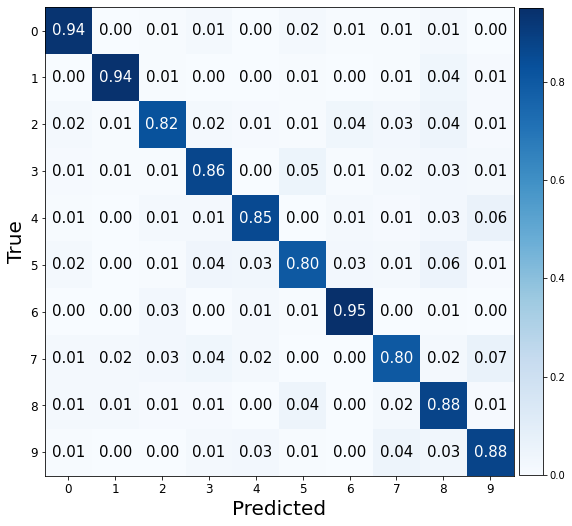



Con 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 0.7917059659957886, f1: 0.8719510344922963, acc: 0.871999979019165
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



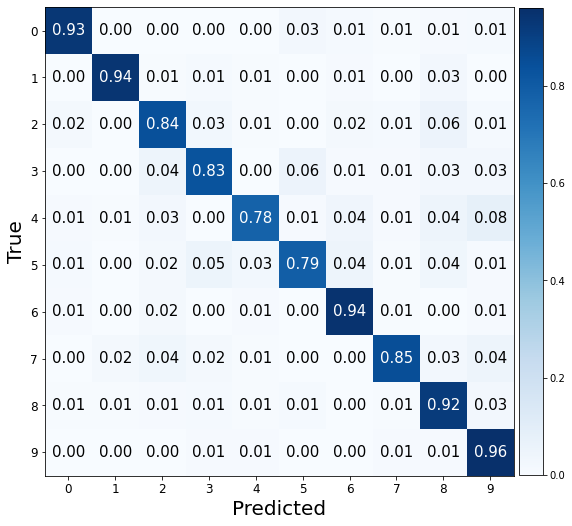



Con 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 0.7545669674873352, f1: 0.8771577838000107, acc: 0.8774999976158142
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



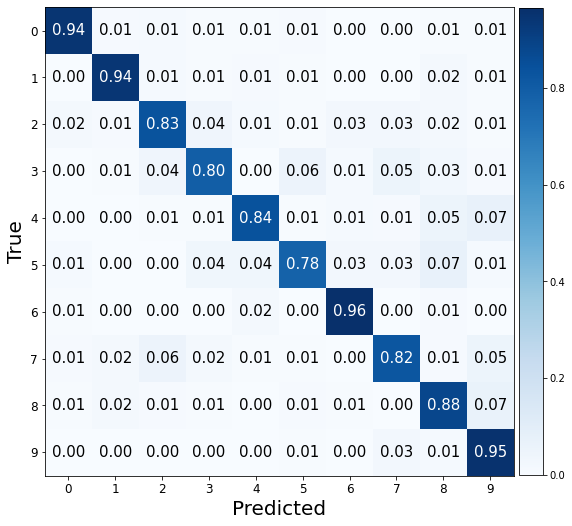



Con 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size se tiene: loss: 0.8591962456703186, f1: 0.8754509929940324, acc: 0.8759999871253967
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



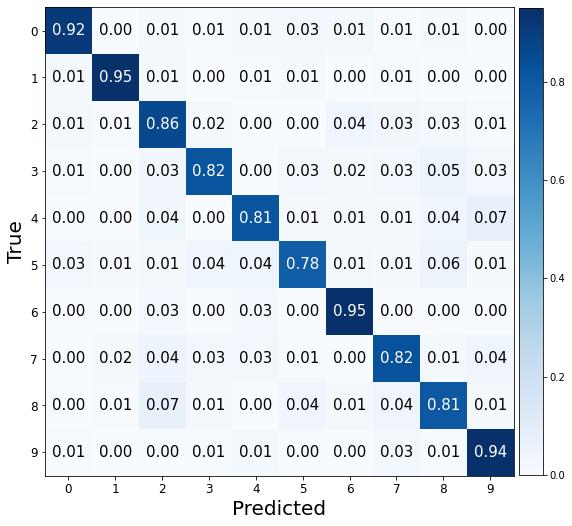



Con 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 256 Batch Size se tiene: loss: 0.6991705894470215, f1: 0.8661426511561157, acc: 0.8665000200271606
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



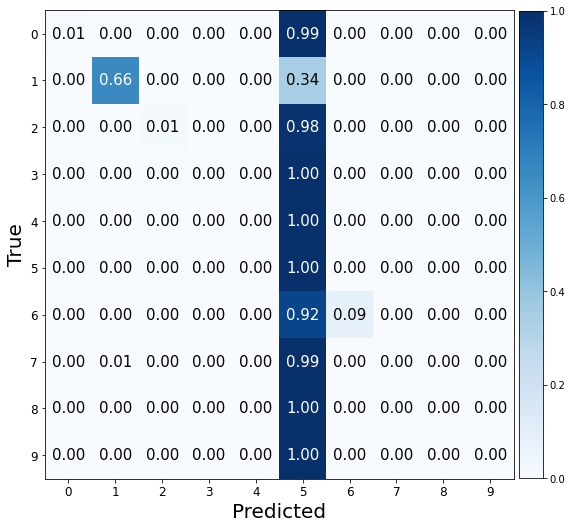



Con 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 2.3134560585021973, f1: 0.11807534671788358, acc: 0.17599999904632568
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



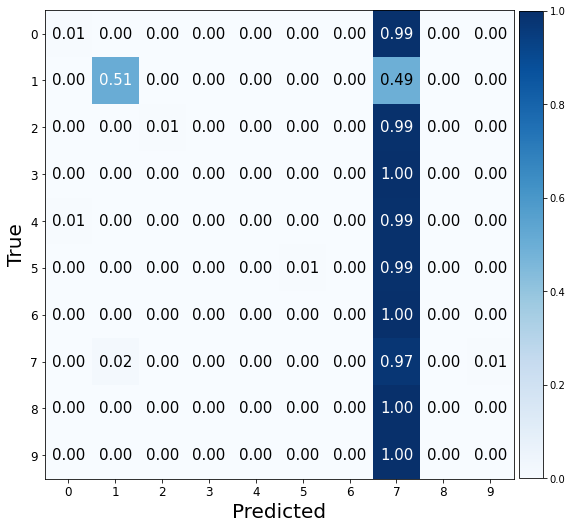



Con 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 4.206766605377197, f1: 0.0878699440392058, acc: 0.14949999749660492
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



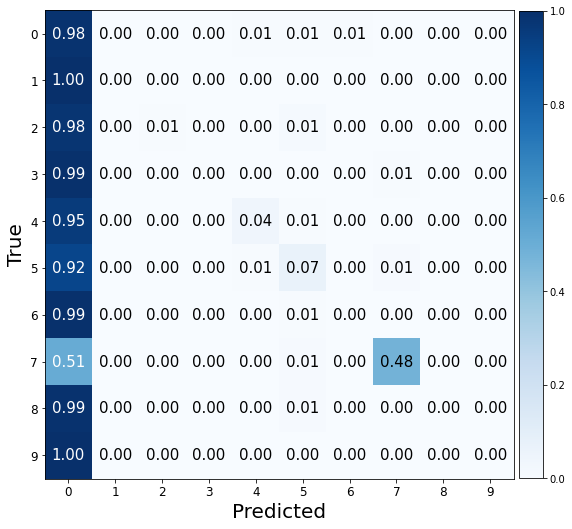



Con 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size se tiene: loss: 2.301924705505371, f1: 0.10440802246511174, acc: 0.15800000727176666
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



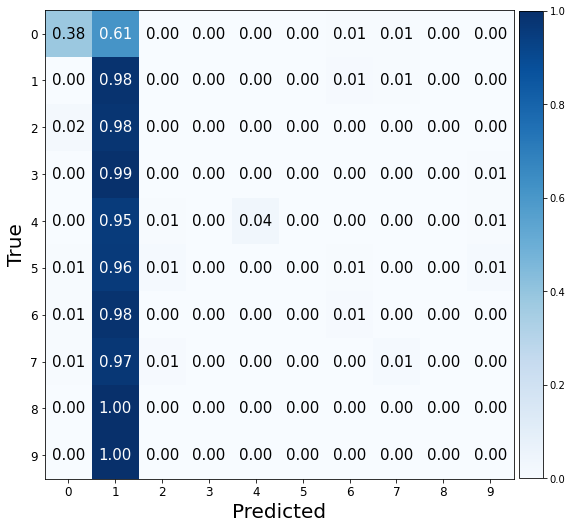



Con 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 256 Batch Size se tiene: loss: 2.4541842937469482, f1: 0.08421184101585241, acc: 0.14249999821186066
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 1024 Batch Size.



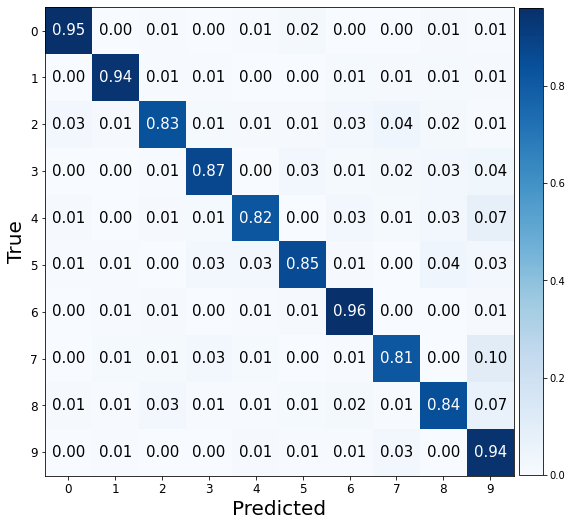



Con 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 1024 Batch Size se tiene: loss: 0.8538828492164612, f1: 0.8843814944999279, acc: 0.8840000033378601
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 1024 Batch Size.



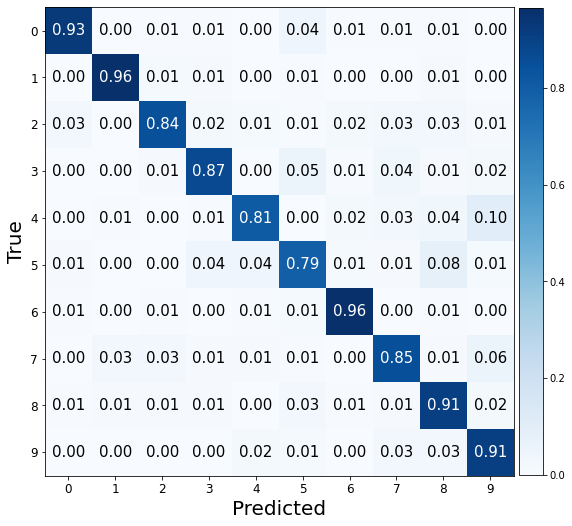



Con 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 1024 Batch Size se tiene: loss: 0.9011934995651245, f1: 0.8824739780586583, acc: 0.8824999928474426
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 1024 Batch Size.



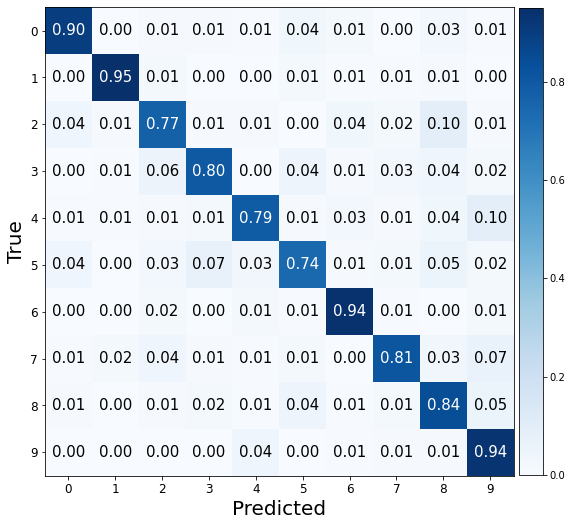



Con 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 1024 Batch Size se tiene: loss: 0.8872762322425842, f1: 0.8467217416180752, acc: 0.847000002861023
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 1024 Batch Size.



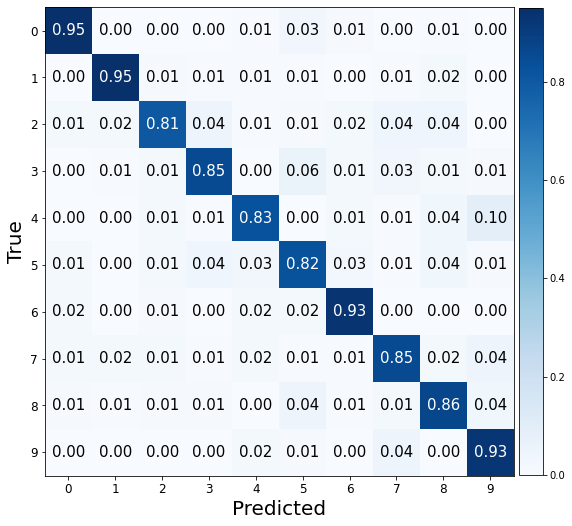



Con 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 1024 Batch Size se tiene: loss: 0.757510244846344, f1: 0.8777412628578498, acc: 0.878000020980835
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 1024 Batch Size.



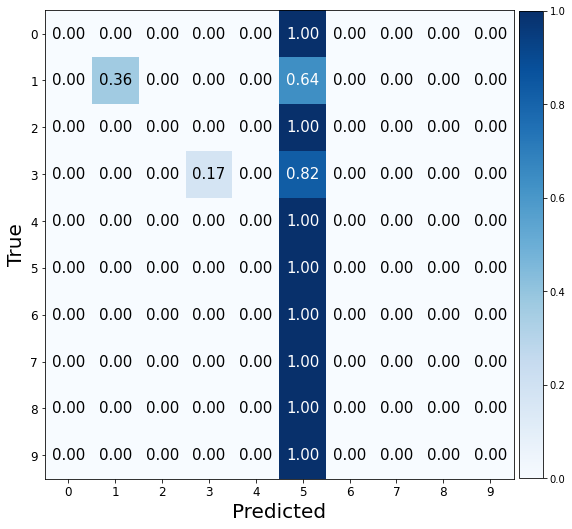



Con 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 1024 Batch Size se tiene: loss: 2.1731417179107666, f1: 0.10238754641342004, acc: 0.15399999916553497
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 1024 Batch Size.



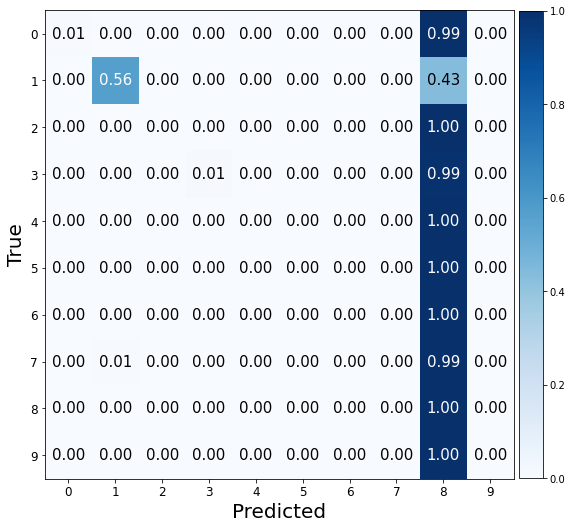



Con 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 1024 Batch Size se tiene: loss: 2.42807936668396, f1: 0.09415281768001615, acc: 0.15800000727176666
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 1024 Batch Size.



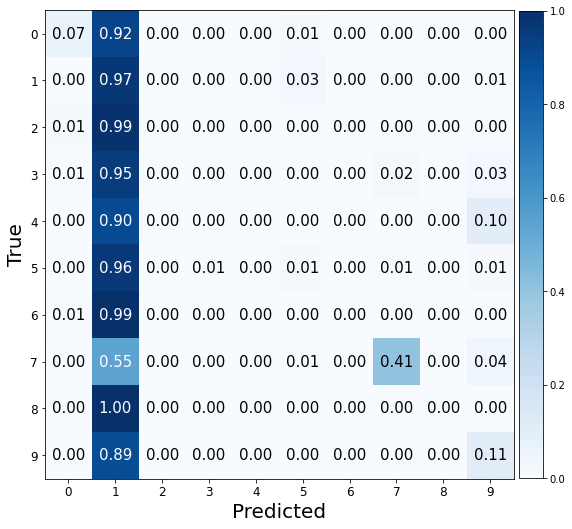



Con 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 1024 Batch Size se tiene: loss: 2.323503255844116, f1: 0.10754814954026364, acc: 0.15649999678134918
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 1024 Batch Size.



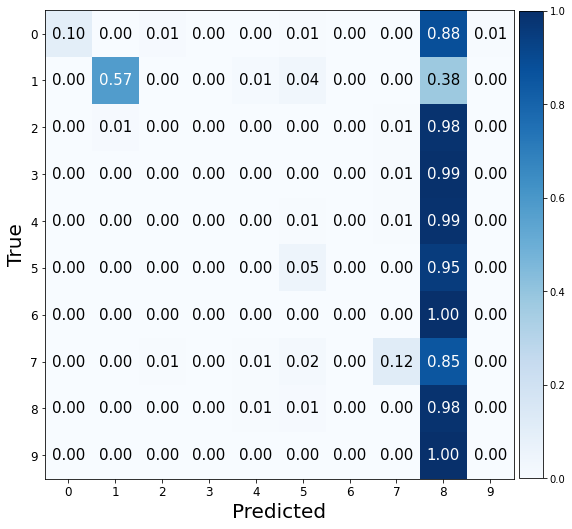



Con 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 1024 Batch Size se tiene: loss: 2.320577383041382, f1: 0.13965038867752272, acc: 0.18250000476837158
*
Esta cargando para 150 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



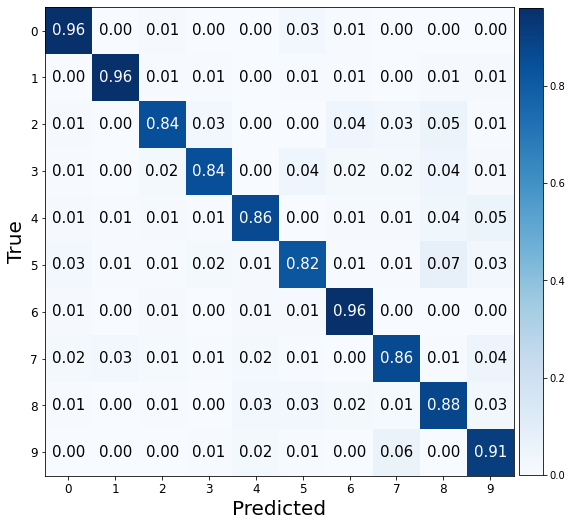



Con 150 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 0.8162794709205627, f1: 0.8898816301415075, acc: 0.8899999856948853
*
Esta cargando para 150 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



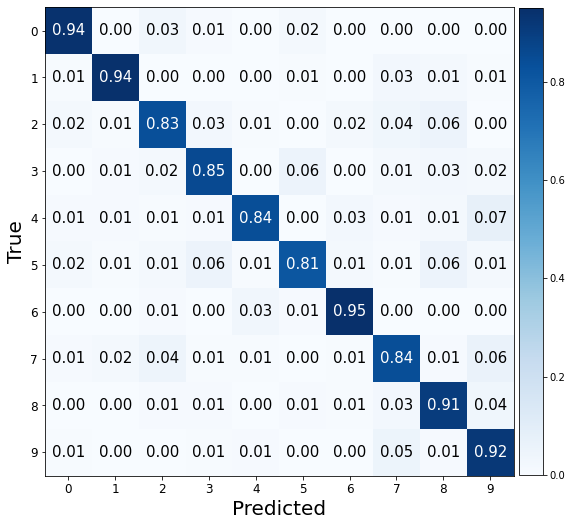



Con 150 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 0.6294196844100952, f1: 0.8839319169580871, acc: 0.8840000033378601
*
Esta cargando para 150 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



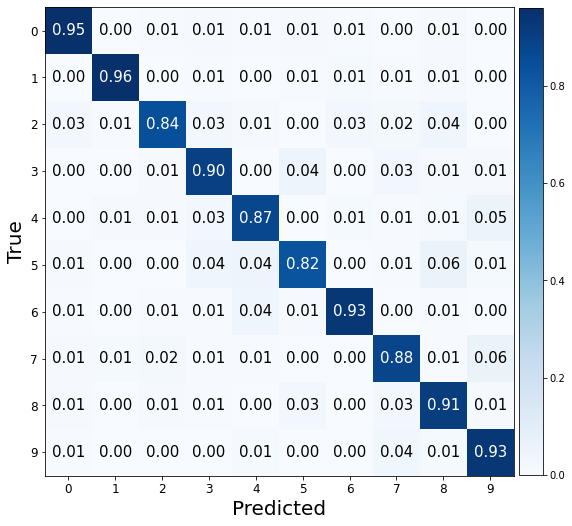



Con 150 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size se tiene: loss: 0.5252525210380554, f1: 0.9003827977256584, acc: 0.9004999995231628
*
Esta cargando para 150 epocas, 100 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



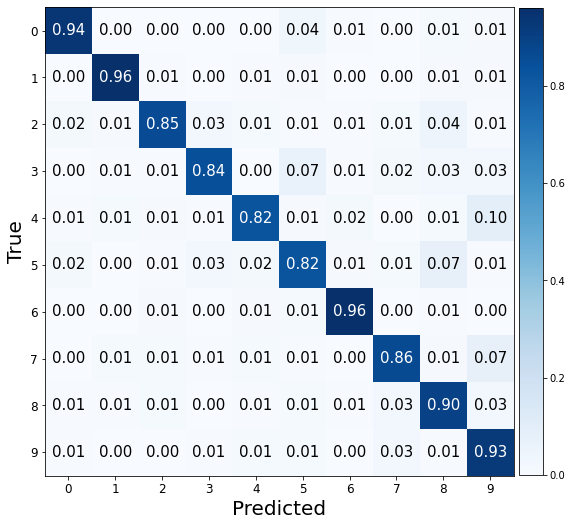



Con 150 epocas, 100 Learning Rate, 0.1 Weight Decay y 256 Batch Size se tiene: loss: 0.7887046337127686, f1: 0.8888843293868289, acc: 0.8884999752044678
*
Esta cargando para 150 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



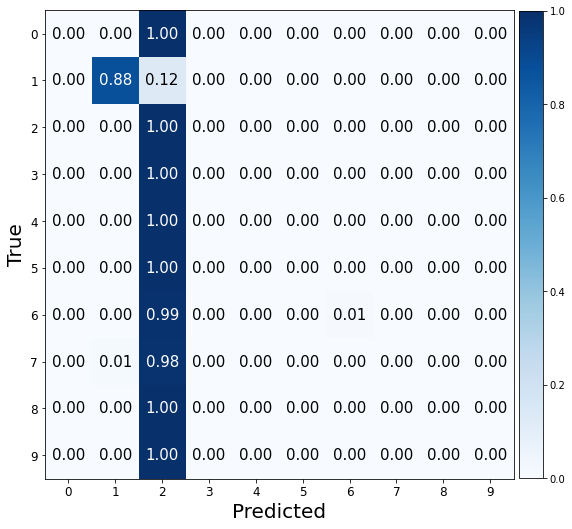



Con 150 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 2.704885482788086, f1: 0.11437477081041436, acc: 0.18850000202655792
*
Esta cargando para 150 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



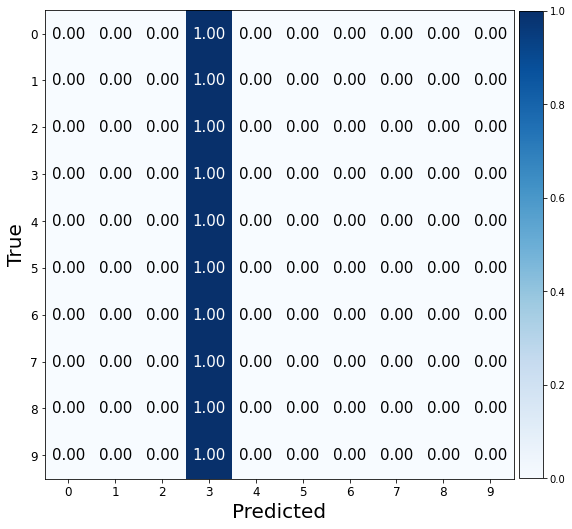



Con 150 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 2.3025879859924316, f1: 0.01818181818181818, acc: 0.10000000149011612
*
Esta cargando para 150 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



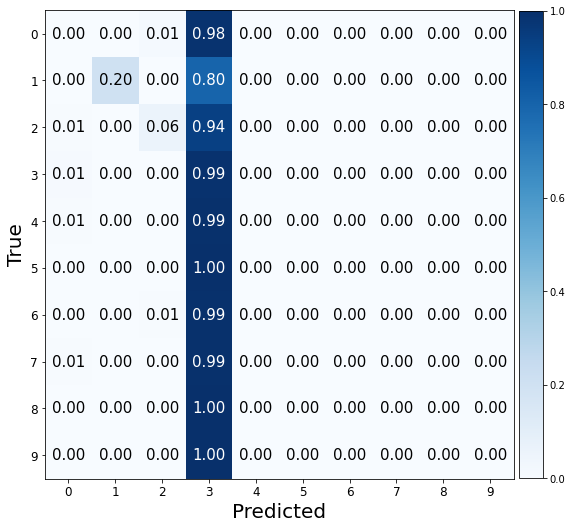



Con 150 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size se tiene: loss: 2.3873393535614014, f1: 0.06295776842761416, acc: 0.125
*
Esta cargando para 150 epocas, 100 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



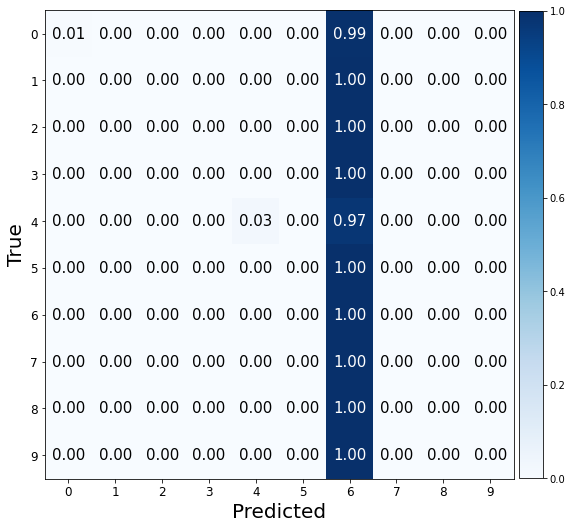



Con 150 epocas, 100 Learning Rate, 0.1 Weight Decay y 256 Batch Size se tiene: loss: 2.267085075378418, f1: 0.024104614221287457, acc: 0.10300000011920929
*
Esta cargando para 150 epocas, 80 Learning Rate, 0.001 Weight Decay y 1024 Batch Size.



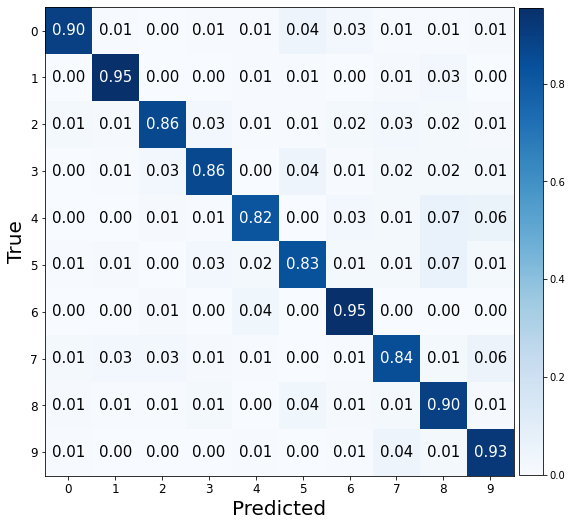



Con 150 epocas, 80 Learning Rate, 0.001 Weight Decay y 1024 Batch Size se tiene: loss: 0.7941433787345886, f1: 0.8850435560325105, acc: 0.8849999904632568
*
Esta cargando para 150 epocas, 100 Learning Rate, 0.001 Weight Decay y 1024 Batch Size.



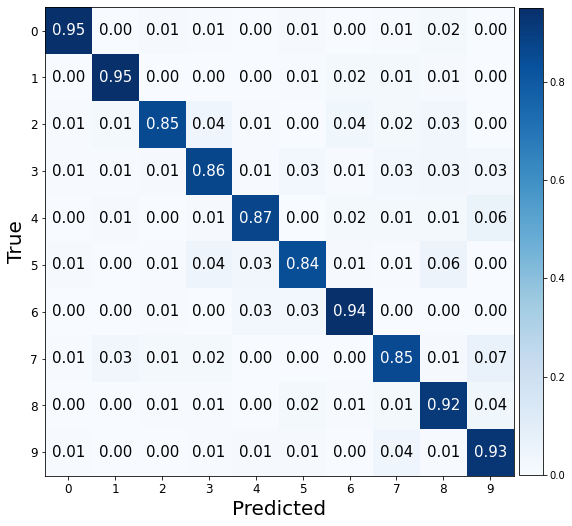



Con 150 epocas, 100 Learning Rate, 0.001 Weight Decay y 1024 Batch Size se tiene: loss: 0.5714018940925598, f1: 0.8965581732708923, acc: 0.8964999914169312
*
Esta cargando para 150 epocas, 80 Learning Rate, 0.1 Weight Decay y 1024 Batch Size.



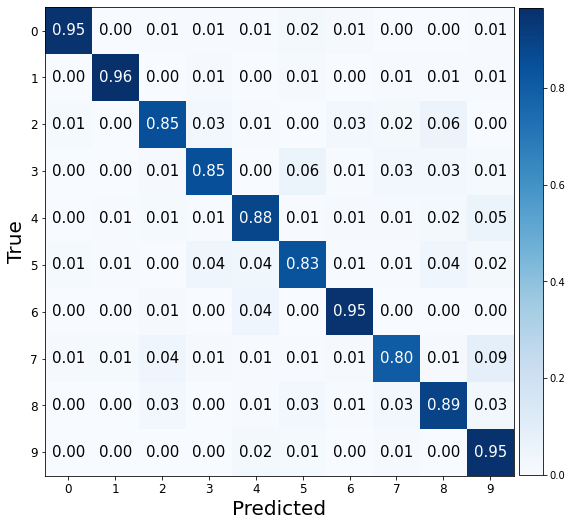



Con 150 epocas, 80 Learning Rate, 0.1 Weight Decay y 1024 Batch Size se tiene: loss: 0.5519917607307434, f1: 0.8922457569165994, acc: 0.8924999833106995
*
Esta cargando para 150 epocas, 100 Learning Rate, 0.1 Weight Decay y 1024 Batch Size.



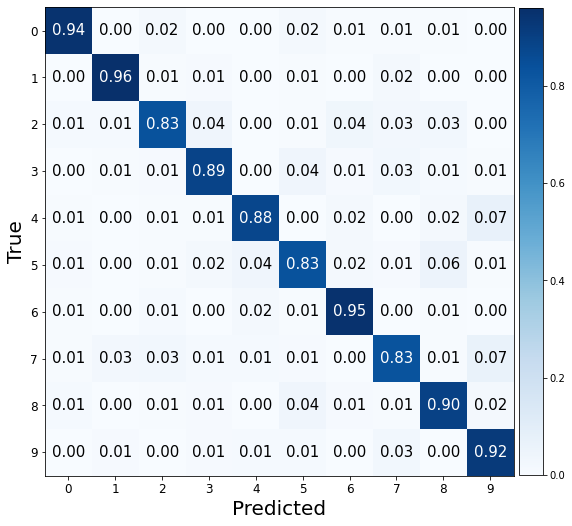



Con 150 epocas, 100 Learning Rate, 0.1 Weight Decay y 1024 Batch Size se tiene: loss: 0.5167132019996643, f1: 0.8926713010643039, acc: 0.8930000066757202
*
Esta cargando para 150 epocas, 80 Learning Rate, 0.001 Weight Decay y 1024 Batch Size.



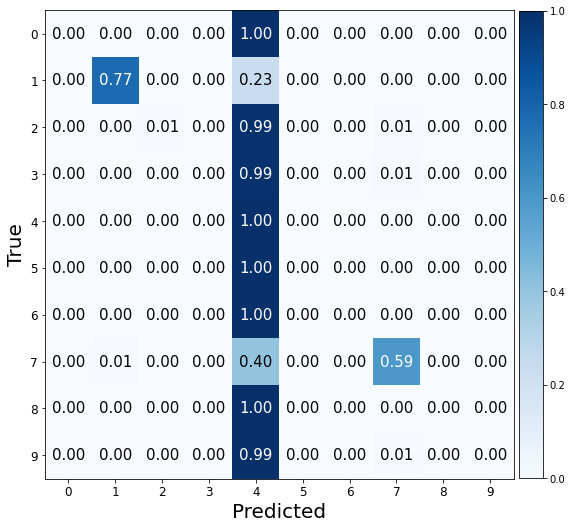



Con 150 epocas, 80 Learning Rate, 0.001 Weight Decay y 1024 Batch Size se tiene: loss: 4.197607040405273, f1: 0.1822622870695697, acc: 0.2370000034570694
*
Esta cargando para 150 epocas, 100 Learning Rate, 0.001 Weight Decay y 1024 Batch Size.



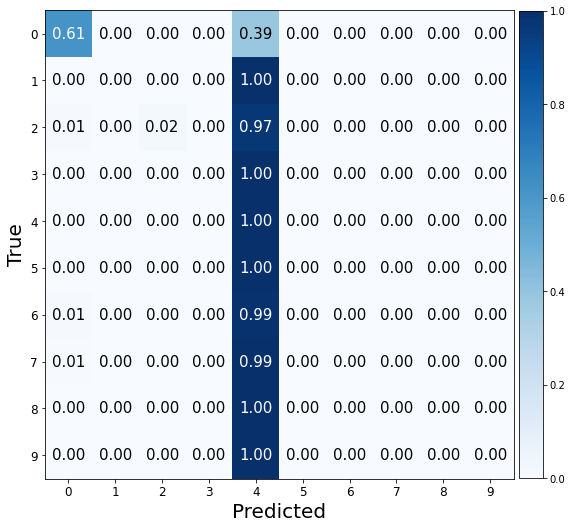



Con 150 epocas, 100 Learning Rate, 0.001 Weight Decay y 1024 Batch Size se tiene: loss: 2.7354516983032227, f1: 0.09787231674699047, acc: 0.16300000250339508
*
Esta cargando para 150 epocas, 80 Learning Rate, 0.1 Weight Decay y 1024 Batch Size.



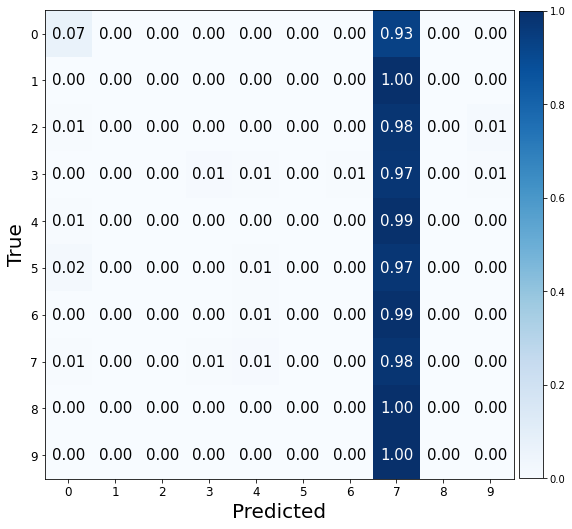



Con 150 epocas, 80 Learning Rate, 0.1 Weight Decay y 1024 Batch Size se tiene: loss: 2.5241830348968506, f1: 0.03273800287729367, acc: 0.10599999874830246
*
Esta cargando para 150 epocas, 100 Learning Rate, 0.1 Weight Decay y 1024 Batch Size.



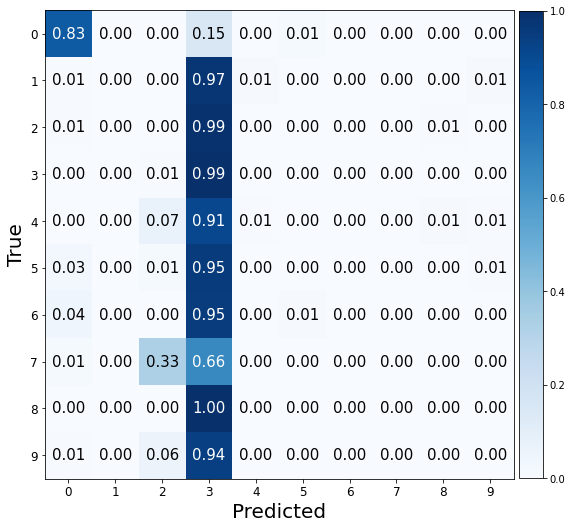



Con 150 epocas, 100 Learning Rate, 0.1 Weight Decay y 1024 Batch Size se tiene: loss: 2.1971631050109863, f1: 0.1084061075356468, acc: 0.1835000067949295
*
*
*
El orden de menor a mayor de los parametros es:
*
Para la perdida:
{'ne50, hd80, wd0.001, bs1024': {'loss': 2.1731417179107666, 'f1': 0.10238754641342004, 'acc': tensor(0.1540)}, 'ne150, hd100, wd0.1, bs1024': {'loss': 2.1971631050109863, 'f1': 0.1084061075356468, 'acc': tensor(0.1835)}, 'ne150, hd100, wd0.1, bs256': {'loss': 2.267085075378418, 'f1': 0.024104614221287457, 'acc': tensor(0.1030)}, 'ne50, hd80, wd0.1, bs256': {'loss': 2.301924705505371, 'f1': 0.10440802246511174, 'acc': tensor(0.1580)}, 'ne150, hd100, wd0.001, bs256': {'loss': 2.3025879859924316, 'f1': 0.01818181818181818, 'acc': tensor(0.1000)}, 'ne50, hd80, wd0.001, bs256': {'loss': 2.3134560585021973, 'f1': 0.11807534671788358, 'acc': tensor(0.1760)}, 'ne50, hd100, wd0.1, bs1024': {'loss': 2.320577383041382, 'f1': 0.13965038867752272, 'acc': tensor(0.1825)}, '

  0%|          | 0/32 [00:00<?, ?it/s]

*
*
Utilizando el modelo 2
*
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



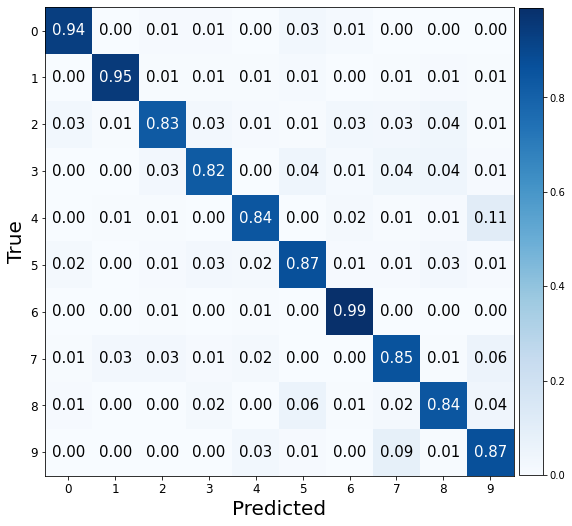



Con 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 0.39447134733200073, f1: 0.8814830701175534, acc: 0.8815000057220459
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



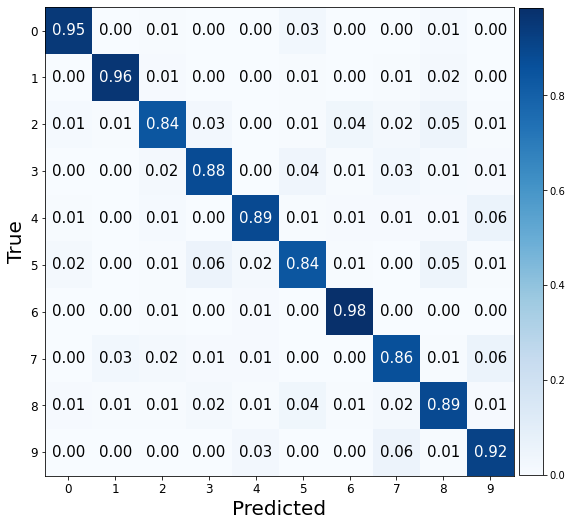



Con 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 0.3668213188648224, f1: 0.9003343576383461, acc: 0.9004999995231628
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



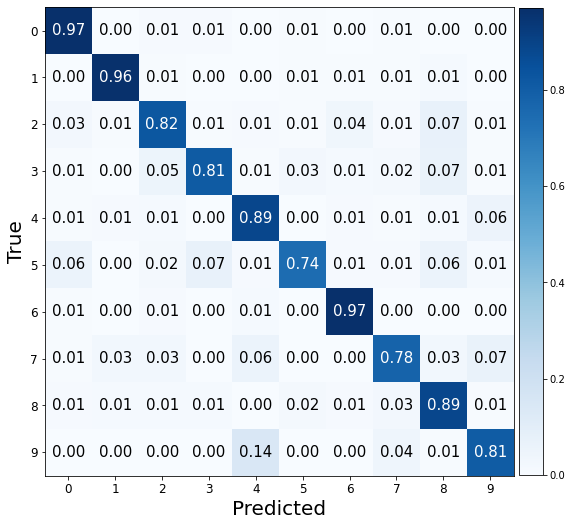



Con 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size se tiene: loss: 0.8709468841552734, f1: 0.8631235400834795, acc: 0.8640000224113464
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



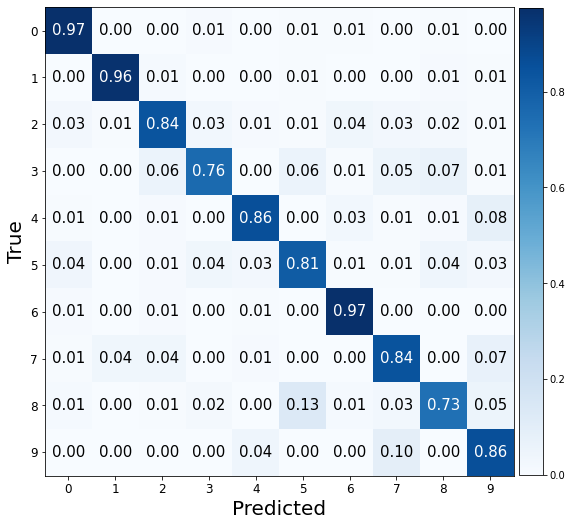



Con 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 256 Batch Size se tiene: loss: 0.7842444777488708, f1: 0.8609920805924155, acc: 0.8619999885559082
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



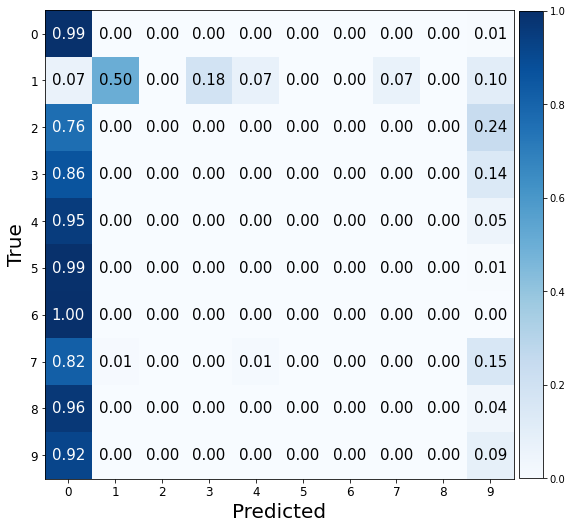



Con 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 2.1694157123565674, f1: 0.09690630747729978, acc: 0.15800000727176666
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



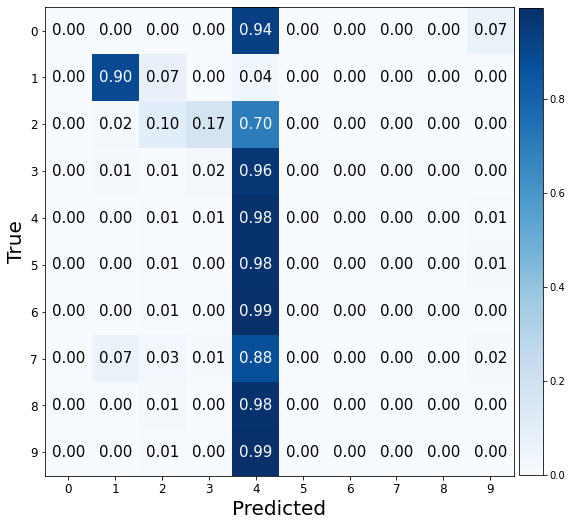



Con 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 2.113424777984619, f1: 0.13095854050024433, acc: 0.2004999965429306
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



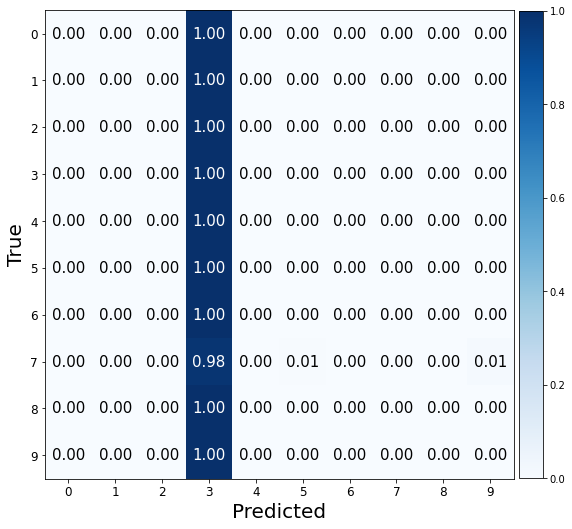



Con 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size se tiene: loss: 2.305724620819092, f1: 0.01821493624772313, acc: 0.10000000149011612
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



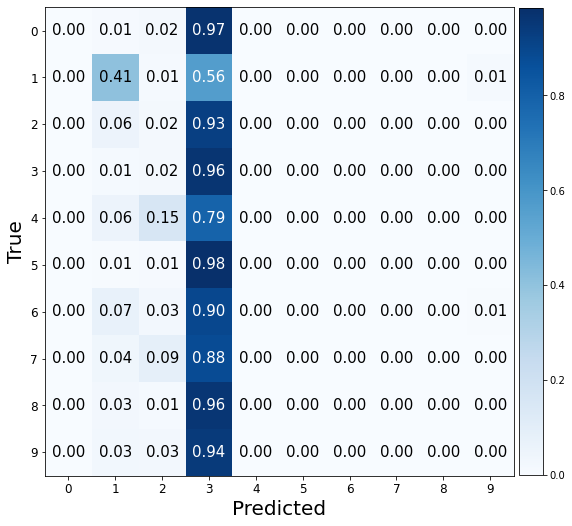



Con 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 256 Batch Size se tiene: loss: 2.312908411026001, f1: 0.06978053184982379, acc: 0.13899999856948853
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 1024 Batch Size.



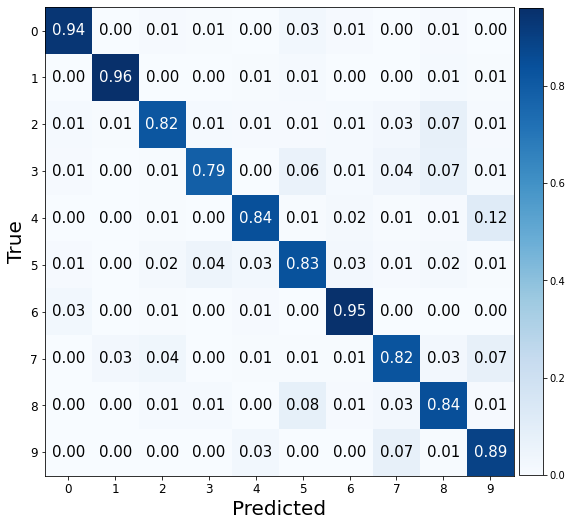



Con 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 1024 Batch Size se tiene: loss: 0.44196298718452454, f1: 0.8691625738802685, acc: 0.8690000176429749
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 1024 Batch Size.



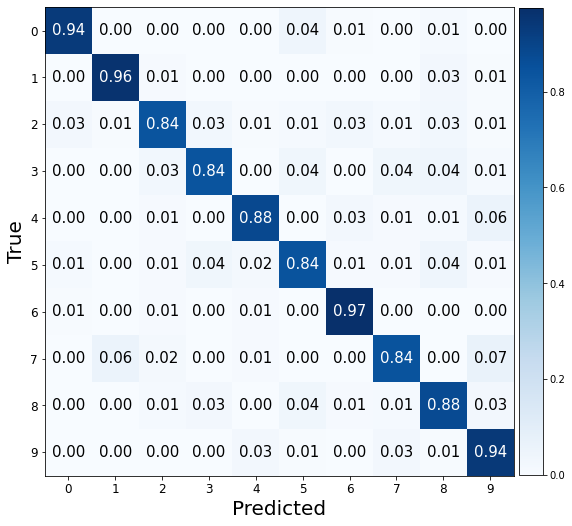



Con 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 1024 Batch Size se tiene: loss: 0.35373711585998535, f1: 0.8932554211538226, acc: 0.8934999704360962
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 1024 Batch Size.



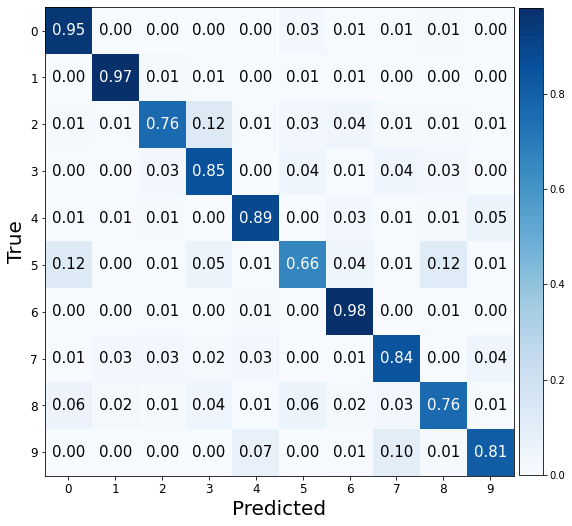



Con 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 1024 Batch Size se tiene: loss: 0.9727386832237244, f1: 0.8447034031322742, acc: 0.847000002861023
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 1024 Batch Size.



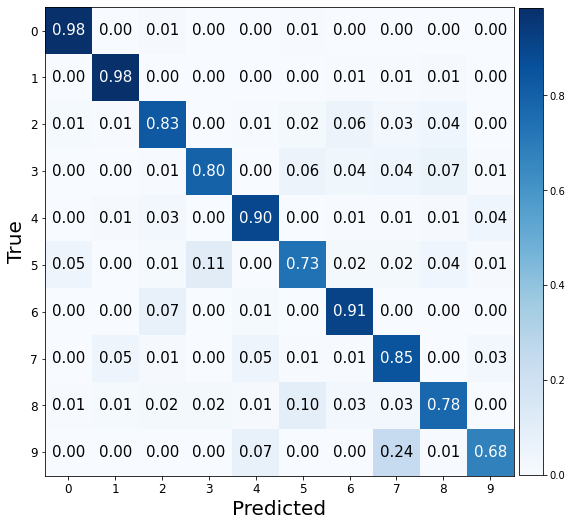



Con 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 1024 Batch Size se tiene: loss: 0.8552601337432861, f1: 0.841594896596367, acc: 0.8429999947547913
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 1024 Batch Size.



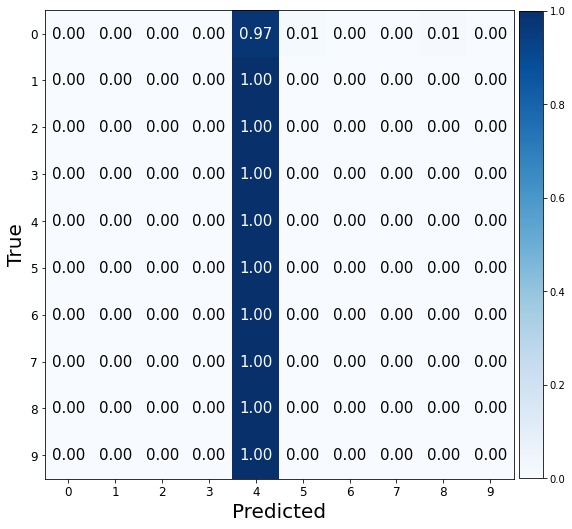



Con 50 epocas, 80 Learning Rate, 0.001 Weight Decay y 1024 Batch Size se tiene: loss: 2.3089866638183594, f1: 0.018223234624145785, acc: 0.10000000149011612
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 1024 Batch Size.



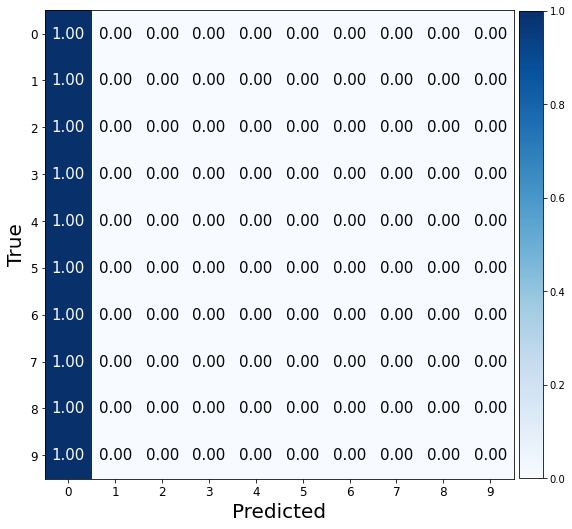



Con 50 epocas, 100 Learning Rate, 0.001 Weight Decay y 1024 Batch Size se tiene: loss: 2.3172411918640137, f1: 0.01818181818181818, acc: 0.10000000149011612
*
Esta cargando para 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 1024 Batch Size.



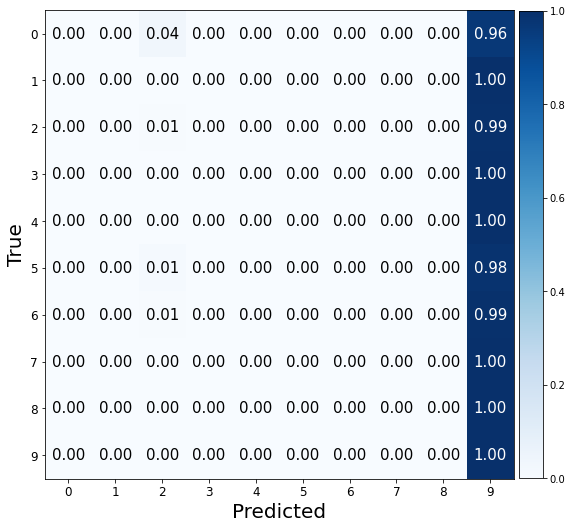



Con 50 epocas, 80 Learning Rate, 0.1 Weight Decay y 1024 Batch Size se tiene: loss: 2.3031365871429443, f1: 0.019224931875409614, acc: 0.10050000250339508
*
Esta cargando para 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 1024 Batch Size.



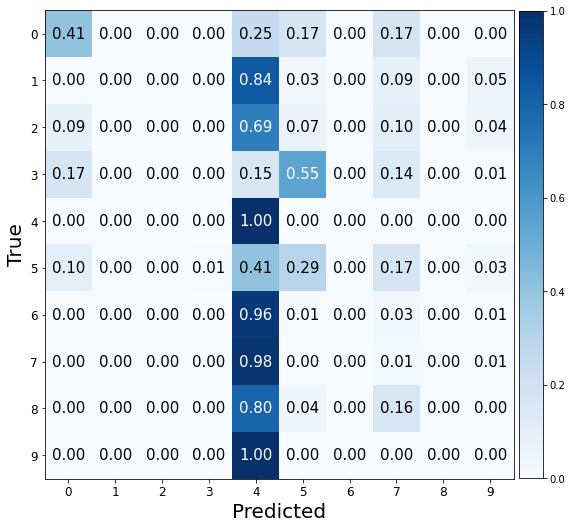



Con 50 epocas, 100 Learning Rate, 0.1 Weight Decay y 1024 Batch Size se tiene: loss: 2.2440598011016846, f1: 0.10005803270209598, acc: 0.17149999737739563
*
Esta cargando para 150 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



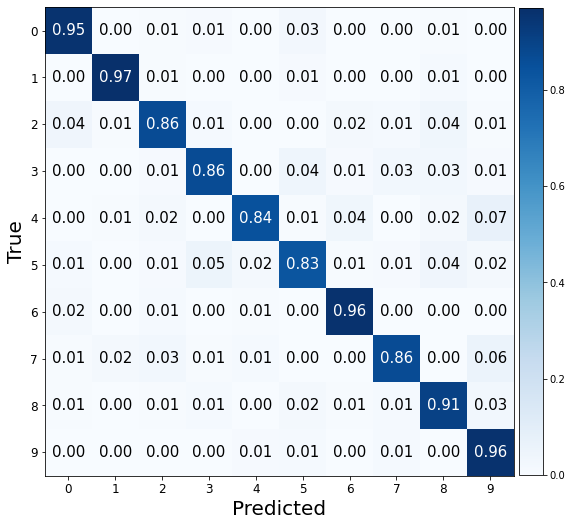



Con 150 epocas, 80 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 0.35196560621261597, f1: 0.9016983863506141, acc: 0.9020000100135803
*
Esta cargando para 150 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size.



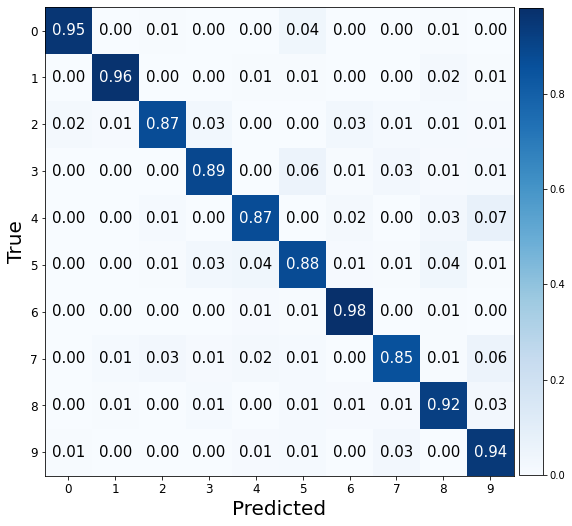



Con 150 epocas, 100 Learning Rate, 0.001 Weight Decay y 256 Batch Size se tiene: loss: 0.28329524397850037, f1: 0.9125002107514216, acc: 0.9125000238418579
*
Esta cargando para 150 epocas, 80 Learning Rate, 0.1 Weight Decay y 256 Batch Size.



In [ ]:
bs_list = [256,1024]
lr_list = [0.001,0.1]
wd_list = [0.001,0.1]
hd_list = [80,100]
ne_list = [50,150]



metodo(ne_list,lr_list,wd_list,bs_list,hd_list)

Los modelos que se utilizan en este trabajo para predecir los números de unas imágenes tienen una capa oculta (modelo 1) y tres capas ocultas (modelo 2). Se estudia el comportamiento de estos modelos para diferentes valores de los metaparámetros que son el Número de épocas, el Learning Rate, el Weight Decay y Batch Size. Como se puede ver en el resultado, en la mayoría de los casos el valor de menor perdida, y mayor accuracy y f1 concuerdan. Sin embargo, esto no ocurre en todos los casos. Para metaparámetros como {} nos podemos dar cuenta que la accuracy es mayor para {} que para {}, aunque el valor de el f1 sea más bajo. Esto probablemente se debe a que hay un sobre ajuste y por lo tanto hay más falsos positivos o falsos negativos. Además, si tomamos los mejores valores de f1 de los modelos 1 y 2, nos podemos dar cuenta que: . 